# Variando el umbral RL

In [14]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [15]:
df = pd.read_csv('../Datos/dataset_muestra50.csv')

ocupacion_columns = ['Ocupacion del Hombre', 'Ocupacion de la Mujer']

df['Clase de Union'] = df['Clase de Union'].replace(9, np.nan)
df['Numero de Nupcias del Hombre'] = df['Numero de Nupcias del Hombre'].replace(9, np.nan)
df['Numero de Nupcias de la Mujer'] = df['Numero de Nupcias de la Mujer'].replace(9, np.nan)
df['Edad del Hombre'] = df['Edad del Hombre'].replace(999, np.nan)
df['Edad de la Mujer'] = df['Nacionalidad de la Mujer'].replace(999, np.nan)
df['Pueblo de Pertenencia del Hombre'] = df['Pueblo de Pertenencia del Hombre'].replace(9, np.nan)
df['Pueblo de Pertenencia de la Mujer'] = df['Pueblo de Pertenencia de la Mujer'].replace(9, np.nan)
df['Nacionalidad del Hombre'] = df['Nacionalidad del Hombre'].replace(9999, np.nan)
df['Nacionalidad de la Mujer'] = df['Nacionalidad de la Mujer'].replace(9999, np.nan)
df['Escolaridad del Hombre'] = df['Escolaridad del Hombre'].replace(9, np.nan)
df['Escolaridad de la Mujer'] = df['Escolaridad de la Mujer'].replace(9, np.nan)
df['Ocupacion del Hombre'] = df['Ocupacion del Hombre'].replace(99, np.nan)
df['Ocupacion de la Mujer'] = df['Ocupacion de la Mujer'].replace(99, np.nan)
df[ocupacion_columns] = df[ocupacion_columns].replace(["IGNORADO", "NEOG"], np.nan)
df['Area Geografica de la Ocurrencia'] = df['Area Geografica de la Ocurrencia'].replace(9, np.nan)

C:\Users\Fabi\AppData\Local\Temp\ipykernel_22020\232818567.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Datos/dataset_muestra50.csv')


In [16]:
# Seleccionar las características para el modelo
selected_features = [
    "Ano Ocurrencia", 
    "Departamento de Ocurrencia", 
    "Edad del Hombre", 
    "Edad de la Mujer",
    "Escolaridad del Hombre",
    "Escolaridad de la Mujer"
]

# Preparar los datos
X = df[selected_features].copy()
y = df['divorcio']

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Objetos de preprocesamiento para pipeline de modelos
preprocesador_categorico = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocesador_numerico = StandardScaler()

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [17]:
# Generación de preprocesador
preprocesador = ColumnTransformer([
    ('one_hot_encoder',preprocesador_categorico, categorical_features),
    ('standard_scaler',preprocesador_numerico, numeric_features)
])

# Características por defecto

In [18]:
# Crear y entrenar el modelo
log_reg = LogisticRegression(solver='liblinear', random_state=42)
start = time.time()
log_reg.fit(X_train, y_train)
tiempo_entrenamiento_lr = time.time() - start

# Realizar predicciones
y_predLR = log_reg.predict(X_test)
y_probaT = log_reg.predict_proba(X_test)[:, 1]

<Figure size 800x600 with 0 Axes>

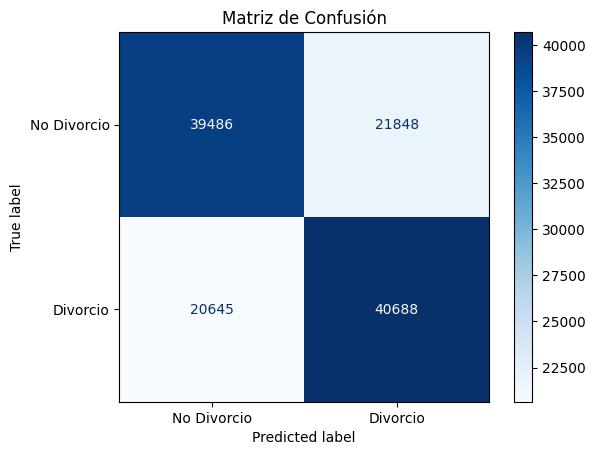

In [19]:
# Matriz de confusión parámetros originales
cm_rl1 = confusion_matrix(y_test, y_predLR)
plt.figure(figsize=(8, 6))
disp_knn1 = ConfusionMatrixDisplay(confusion_matrix=cm_rl1, display_labels=['No Divorcio', 'Divorcio'])
disp_knn1.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

## El "mejor" Umbral

C:\Users\Fabi\AppData\Local\Temp\ipykernel_22020\3098330656.py:7: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


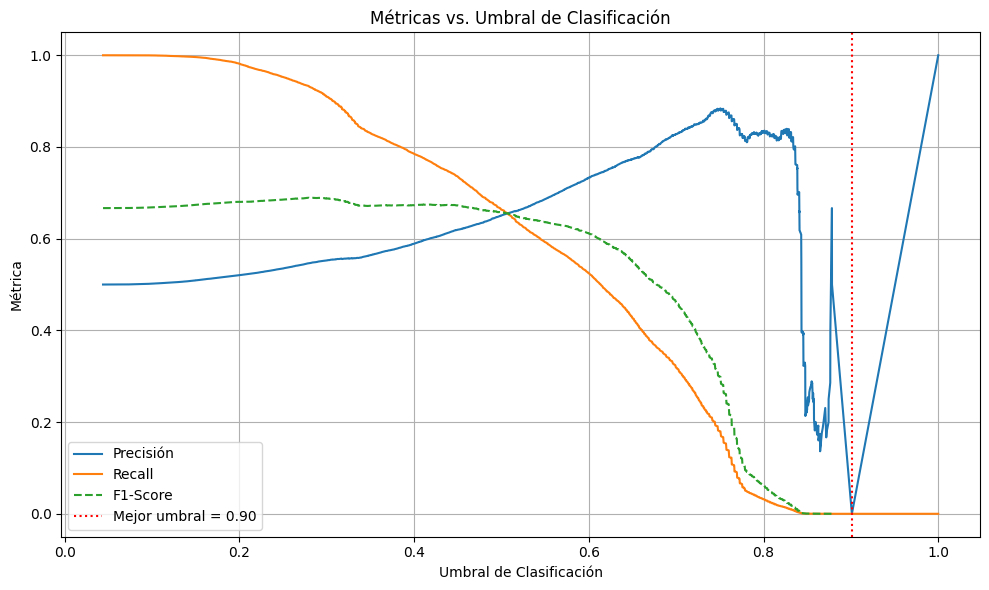

In [20]:
from sklearn.metrics import precision_recall_curve

# Calcular curvas
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probaT)

# Calcular F1-score para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
thresholds = np.append(thresholds, 1.0)  # Añadir el último punto para alinearlo con F1

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precisión')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score', linestyle='--')

# Mejor threshold según F1
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Mejor umbral = {best_threshold:.2f}')

# Detalles del gráfico
plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Métricas vs. Umbral de Clasificación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Realizar predicciones
custom_threshold = best_threshold
y_predT = (y_probaT >= custom_threshold).astype(int)

<Figure size 800x600 with 0 Axes>

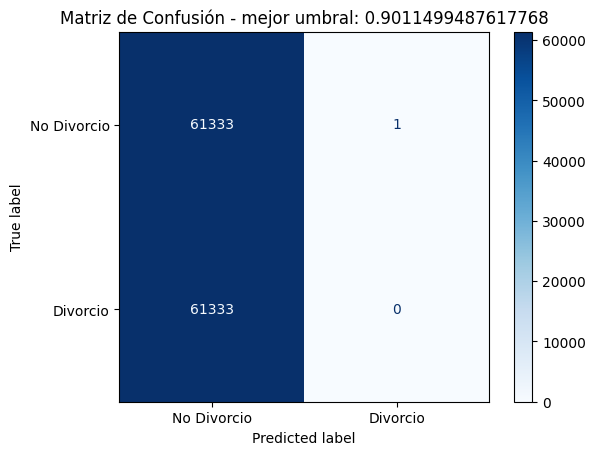

In [22]:
# Matriz de confusión parámetros originales
cm_rl2 = confusion_matrix(y_test, y_predT)
plt.figure(figsize=(8, 6))
disp_knn1 = ConfusionMatrixDisplay(confusion_matrix=cm_rl2, display_labels=['No Divorcio', 'Divorcio'])
disp_knn1.plot(cmap='Blues')
plt.title('Matriz de Confusión - mejor umbral: ' + str(best_threshold))
plt.show()

## Otros ejemplos

<Figure size 800x600 with 0 Axes>

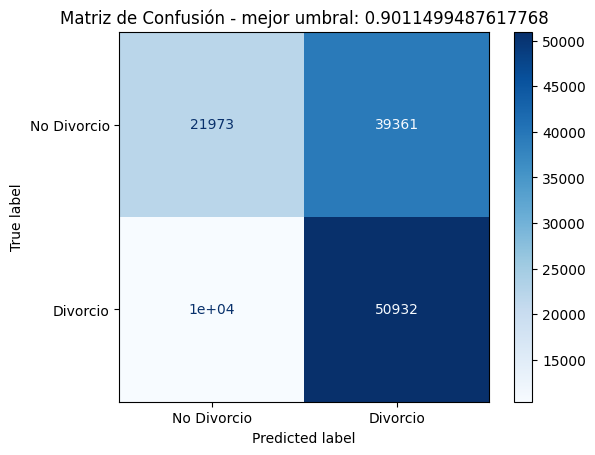

In [23]:
# Realizar predicciones
custom_threshold = 0.35
y_predT = (y_probaT >= custom_threshold).astype(int)

# Matriz de confusión parámetros originales
cm_rl3 = confusion_matrix(y_test, y_predT)
plt.figure(figsize=(8, 6))
disp_knn1 = ConfusionMatrixDisplay(confusion_matrix=cm_rl3, display_labels=['No Divorcio', 'Divorcio'])
disp_knn1.plot(cmap='Blues')
plt.title('Matriz de Confusión - mejor umbral: ' + str(best_threshold))
plt.show()

<Figure size 800x600 with 0 Axes>

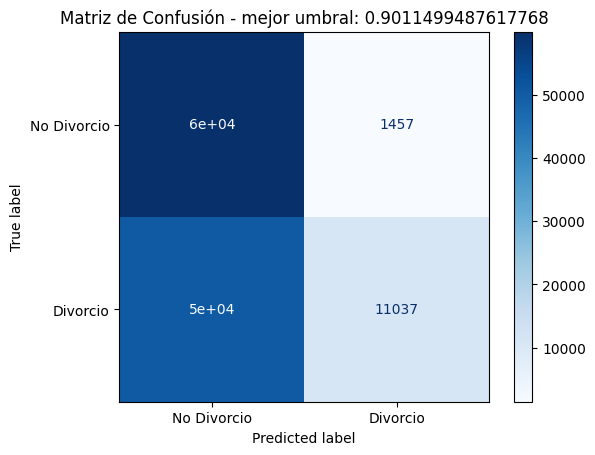

In [24]:
# Realizar predicciones
custom_threshold = 0.75
y_predT = (y_probaT >= custom_threshold).astype(int)

# Matriz de confusión parámetros originales
cm_rl4 = confusion_matrix(y_test, y_predT)
plt.figure(figsize=(8, 6))
disp_knn1 = ConfusionMatrixDisplay(confusion_matrix=cm_rl4, display_labels=['No Divorcio', 'Divorcio'])
disp_knn1.plot(cmap='Blues')
plt.title('Matriz de Confusión - mejor umbral: ' + str(best_threshold))
plt.show()